In [1]:
import pandas as pd
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from prophet import Prophet
from matplotlib.lines import Line2D
from matplotlib.dates import YearLocator, DateFormatter
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json
from datetime import datetime
from datetime import timedelta
import warnings


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('assets/csv/PEDE_PASSOS_DATASET_FIAP.csv', sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  728 non-null    object 
 1   NOME                           1349 non-null   object 
 2   IDADE_ALUNO_2020               728 non-null    object 
 3   ANOS_PM_2020                   728 non-null    object 
 4   FASE_TURMA_2020                728 non-null    object 
 5   PONTO_VIRADA_2020              702 non-null    object 
 6   INDE_2020                      728 non-null    object 
 7   INDE_CONCEITO_2020             728 non-null    object 
 8   PEDRA_2020                     728 non-null    object 
 9   DESTAQUE_IEG_2020              728 non-null    object 
 10  DESTAQUE_IDA_2020              728 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       728 non-null    o

In [4]:
def filter_columns(df, filters: list): # adiciono no array o padrão que existe nas colunas e que não quero que tenha na saída final
    selected_columns = [True] * len(df.columns)  # Inicializa todas as colunas como True
    for index, column in enumerate(df.columns):
        if any(filter in column for filter in filters): selected_columns[index] = False
    return df[df.columns[selected_columns]]

In [5]:
def cleaning_dataset(df):
  _df = df.dropna(subset=df.columns.difference(['NOME']), how='all') # executa o dropna para todas as colunas sem visualizar a coluna NOME
  _df = _df[~_df.isna().all(axis=1)] # remove linhas com apenas NaN, se tiver algum dado na linha não remove
  return _df

In [6]:
# Função para extrair o valor numérico da string
def extrair_numero(valor):
    # Encontrar todos os números na string e retornar o primeiro encontrado
    numeros = re.findall(r'\d+', str(valor))
    if numeros:
        return int(numeros[0])
    else:
        return None

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  728 non-null    object 
 1   NOME                           1349 non-null   object 
 2   IDADE_ALUNO_2020               728 non-null    object 
 3   ANOS_PM_2020                   728 non-null    object 
 4   FASE_TURMA_2020                728 non-null    object 
 5   PONTO_VIRADA_2020              702 non-null    object 
 6   INDE_2020                      728 non-null    object 
 7   INDE_CONCEITO_2020             728 non-null    object 
 8   PEDRA_2020                     728 non-null    object 
 9   DESTAQUE_IEG_2020              728 non-null    object 
 10  DESTAQUE_IDA_2020              728 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       728 non-null    o

In [8]:
df = df.round(2)

In [9]:
print(df.dtypes)

INSTITUICAO_ENSINO_ALUNO_2020     object
NOME                              object
IDADE_ALUNO_2020                  object
ANOS_PM_2020                      object
FASE_TURMA_2020                   object
                                  ...   
INDICADO_BOLSA_2022               object
PONTO_VIRADA_2022                 object
IPV_2022                         float64
IAN_2022                         float64
NIVEL_IDEAL_2022                  object
Length: 69, dtype: object


In [10]:
# Filtrando 2020
df_2020 = filter_columns(df, ['2021', '2022'])

# Filtrando 2021
df_2021 = filter_columns(df, ['2020', '2022'])

# Filtrando 2022
df_2022 = filter_columns(df, ['2020', '2021'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  728 non-null    object 
 1   NOME                           1349 non-null   object 
 2   IDADE_ALUNO_2020               728 non-null    object 
 3   ANOS_PM_2020                   728 non-null    object 
 4   FASE_TURMA_2020                728 non-null    object 
 5   PONTO_VIRADA_2020              702 non-null    object 
 6   INDE_2020                      728 non-null    object 
 7   INDE_CONCEITO_2020             728 non-null    object 
 8   PEDRA_2020                     728 non-null    object 
 9   DESTAQUE_IEG_2020              728 non-null    object 
 10  DESTAQUE_IDA_2020              728 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       728 non-null    o

In [12]:
# Analisando a idade dos alunos

df_idade = df
df_idade['IDADE_ALUNO_2020'] = pd.to_numeric(df['IDADE_ALUNO_2020'], errors='coerce')
df_idade['IDADE_ALUNO_2020'] = df['IDADE_ALUNO_2020'].fillna(0).astype(int)
df_idade = df.dropna(subset=['IDADE_ALUNO_2020'])
df_idade = df[df['IDADE_ALUNO_2020'] > 0]

In [13]:
df_idade.info()

<class 'pandas.core.frame.DataFrame'>
Index: 727 entries, 0 to 1347
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  727 non-null    object 
 1   NOME                           727 non-null    object 
 2   IDADE_ALUNO_2020               727 non-null    int32  
 3   ANOS_PM_2020                   727 non-null    object 
 4   FASE_TURMA_2020                727 non-null    object 
 5   PONTO_VIRADA_2020              701 non-null    object 
 6   INDE_2020                      727 non-null    object 
 7   INDE_CONCEITO_2020             727 non-null    object 
 8   PEDRA_2020                     727 non-null    object 
 9   DESTAQUE_IEG_2020              727 non-null    object 
 10  DESTAQUE_IDA_2020              727 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       727 non-null    object 

In [14]:
# Desvendando os dados sobre a idade dos alunos

idade_media = df_idade['IDADE_ALUNO_2020'].mean()
idade_mediana = df_idade['IDADE_ALUNO_2020'].median()
idade_variancia = df_idade['IDADE_ALUNO_2020'].var()
idade_desvio_padrao = df_idade['IDADE_ALUNO_2020'].std()
idade_moda = df_idade['IDADE_ALUNO_2020'].mode()[0]

print(f"Média: {idade_media}")
print(f"Mediana: {idade_mediana}")
print(f"Desvio Padrão: {idade_desvio_padrao}")
print(f"Variância: {idade_variancia}")
print(f"Moda: {idade_moda}")

Média: 12.408528198074277
Mediana: 12.0
Desvio Padrão: 2.829806699677048
Variância: 8.007805957537107
Moda: 10


In [15]:
idade_counts = df_idade['IDADE_ALUNO_2020'].value_counts().sort_index()

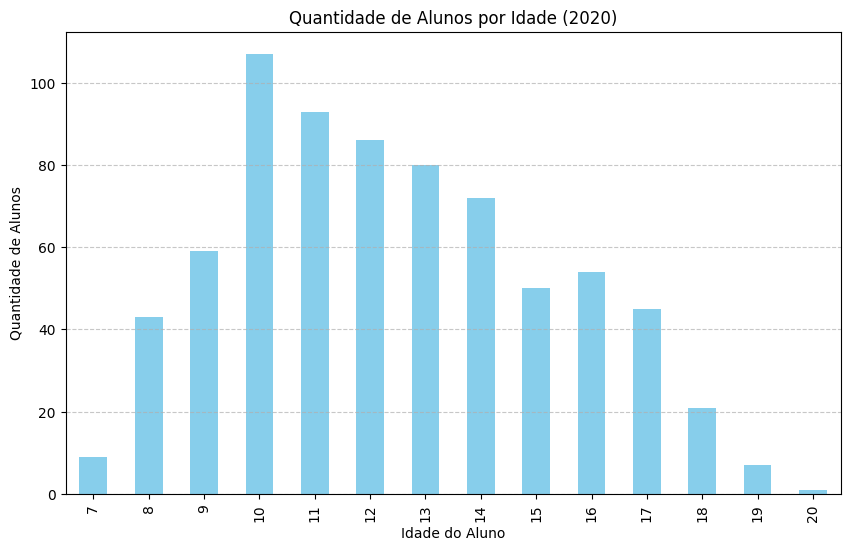

In [16]:
# Distribuição de idade dos alunos

plt.figure(figsize=(10, 6))
idade_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Idade do Aluno')
plt.ylabel('Quantidade de Alunos')
plt.title('Quantidade de Alunos por Idade (2020)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

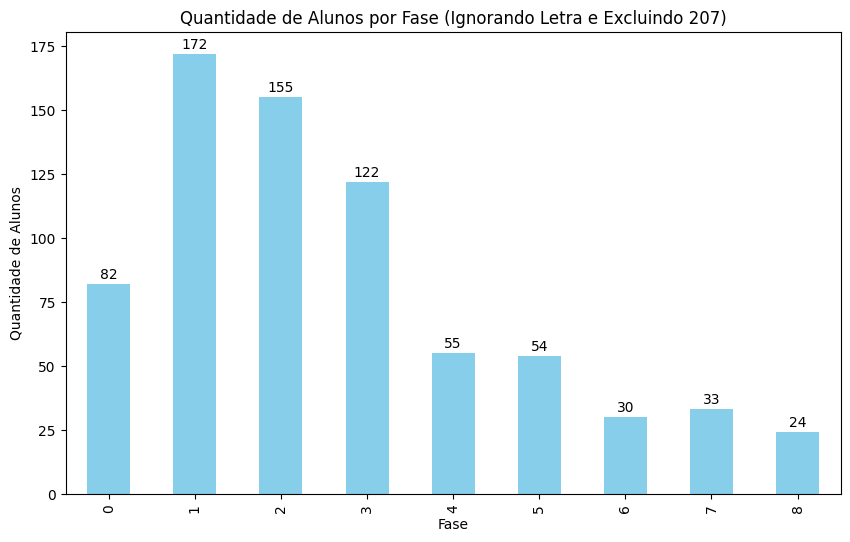

In [17]:
df_fase = df.dropna(subset=['FASE_TURMA_2020'])

# Função para extrair apenas o número da fase (ignora a letra)
df_fase['Fase_Numero'] = df_fase['FASE_TURMA_2020'].str.extract(r'(\d+)')

# Remover os valores onde a fase é '207'
df_fase = df_fase[df_fase['Fase_Numero'] != '207']

# Contar a quantidade de alunos por fase (apenas pelo número)
contagem_fases = df_fase['Fase_Numero'].value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = contagem_fases.plot(kind='bar', color='skyblue')

# Adicionar títulos e rótulos
plt.title('Quantidade de Alunos por Fase (Ignorando Letra e Excluindo 207)')
plt.xlabel('Fase')
plt.ylabel('Quantidade de Alunos')
for idx, valor in enumerate(contagem_fases):
    bars.text(idx, valor + 1, str(valor), ha='center', va='bottom')
    
plt.show()


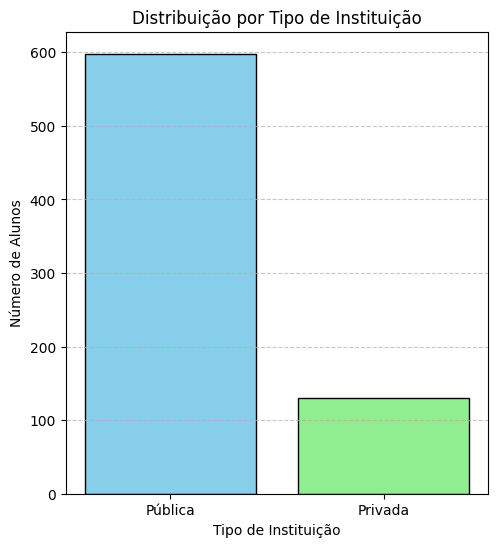

In [18]:
# Distribuição das instituições de ensino dos alunos

df_instituicao = df.dropna(subset=['INSTITUICAO_ENSINO_ALUNO_2020'])

# Contar a quantidade de alunos por tipo de instituição

df_instituicao['Tipo_Instituicao'] = df_instituicao['INSTITUICAO_ENSINO_ALUNO_2020'].apply(
    lambda x: 'Pública' if 'Pública' in str(x) else 'Privada')

# Contar a quantidade de alunos em cada tipo de instituição
contagem_tipo_instituicao = df_instituicao['Tipo_Instituicao'].value_counts()

# Filtrar apenas instituições privadas
instituicoes_privadas = df_instituicao[df_instituicao['Tipo_Instituicao'] == 'Privada']
contagem_instituicoes_privadas = instituicoes_privadas['INSTITUICAO_ENSINO_ALUNO_2020'].value_counts()

# Gráfico de distribuição por tipo de instituição

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(contagem_tipo_instituicao.index, contagem_tipo_instituicao.values, color=['skyblue', 'lightgreen'], edgecolor='black')
plt.xlabel('Tipo de Instituição')
plt.ylabel('Número de Alunos')
plt.title('Distribuição por Tipo de Instituição')
plt.grid(axis='y', linestyle='--', alpha=0.7)




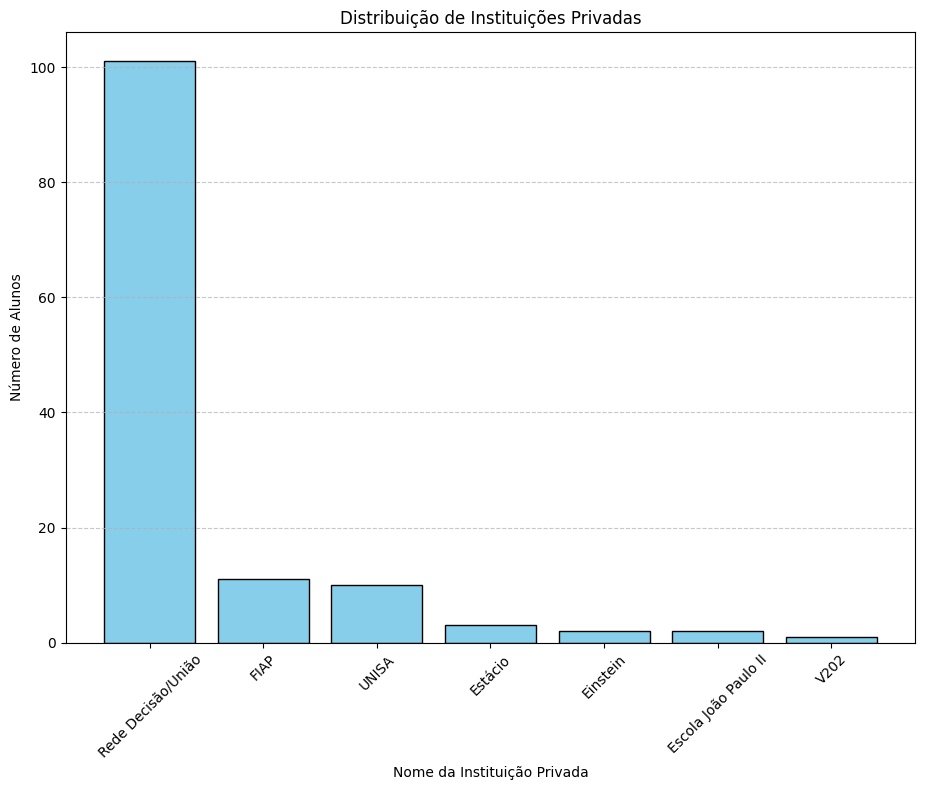

In [19]:
# Gráfico de distribuição de instituições privadas (se houver)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 2)
plt.bar(contagem_instituicoes_privadas.index, contagem_instituicoes_privadas.values, color='skyblue', edgecolor='black')
plt.xlabel('Nome da Instituição Privada')
plt.ylabel('Número de Alunos')
plt.title('Distribuição de Instituições Privadas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [20]:
# Verificando e tratando os alunos que atingiram o ponto de virada em 2020.

colunas_ponto_virada = df[['PONTO_VIRADA_2020','PONTO_VIRADA_2021','PONTO_VIRADA_2022']]

ponto_atingido = ['Sim']

# Contar ocorrências para cada ano
contagem_por_ano = {col: colunas_ponto_virada[col].value_counts() for col in colunas_ponto_virada.columns}

# Exibir os resultados
for ano, contagem in contagem_por_ano.items():
    print(f"\nContagem de alunos que atingiram o {ano}:")
    print(contagem)


Contagem de alunos que atingiram o PONTO_VIRADA_2020:
PONTO_VIRADA_2020
Não      607
Sim       94
D9600      1
Name: count, dtype: int64

Contagem de alunos que atingiram o PONTO_VIRADA_2021:
PONTO_VIRADA_2021
Não       576
Sim       108
#NULO!      2
Name: count, dtype: int64

Contagem de alunos que atingiram o PONTO_VIRADA_2022:
PONTO_VIRADA_2022
Não    749
Sim    113
Name: count, dtype: int64


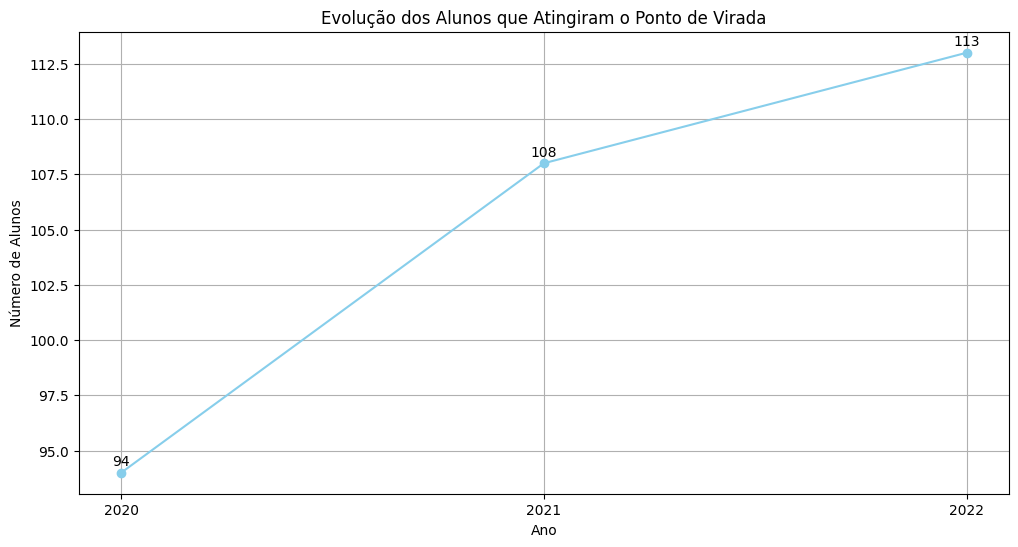

In [21]:
contagem_2020 = colunas_ponto_virada['PONTO_VIRADA_2020'].value_counts().get(ponto_atingido, 0)
contagem_2021 = colunas_ponto_virada['PONTO_VIRADA_2021'].value_counts().get(ponto_atingido, 0)
contagem_2022 = colunas_ponto_virada['PONTO_VIRADA_2022'].value_counts().get(ponto_atingido, 0)

# Crie uma lista com os valores de contagem
contagens = [int(contagem_2020), int(contagem_2021), int(contagem_2022)]

# Anos para o eixo X
anos = ['2020', '2021', '2022']

# Plote o gráfico
plt.figure(figsize=(12, 6))
plt.plot(anos, contagens, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Ano')
plt.ylabel('Número de Alunos')
plt.title('Evolução dos Alunos que Atingiram o Ponto de Virada')
plt.grid(True)
plt.xticks(anos)

for idx, valor in enumerate(contagens):
    plt.annotate(str(valor), (anos[idx], valor), textcoords="offset points", xytext=(0,5), ha='center')

plt.show() 

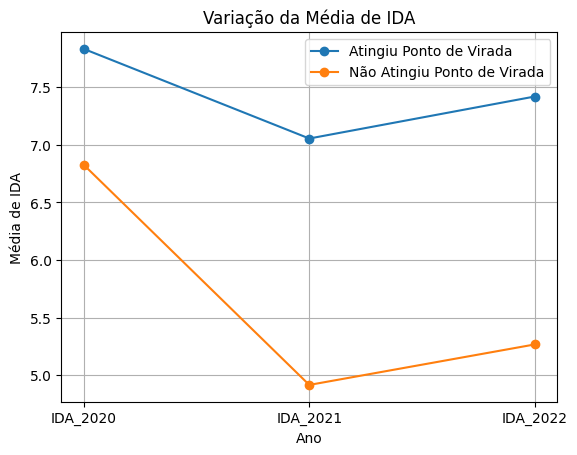

In [22]:
# Converter colunas de IDA para numérico, substituindo erros por NaN
df['IDA_2020'] = pd.to_numeric(df['IDA_2020'], errors='coerce')
df['IDA_2021'] = pd.to_numeric(df['IDA_2021'], errors='coerce')
df['IDA_2022'] = pd.to_numeric(df['IDA_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IDA para cada grupo
media_atingiu_pv = atingiu_pv[['IDA_2020', 'IDA_2021', 'IDA_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IDA_2020', 'IDA_2021', 'IDA_2022']].mean()

# Criar um gráfico para comparar as médias de IDA para os dois grupos
anos = ['IDA_2020', 'IDA_2021', 'IDA_2022']

plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o')

# Adicionar título e rótulos aos eixos
plt.title('Variação da Média de IDA')
plt.xlabel('Ano')
plt.ylabel('Média de IDA')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
# Verificando e tratando a média IDA.

df_ida = df[['NOME', 'IDA_2020', 'IDA_2021', 'IDA_2022']]
print(df_ida)

            NOME  IDA_2020  IDA_2021  IDA_2022
0        ALUNO-1  7.000000       8.8       NaN
1        ALUNO-2       NaN       NaN      8.82
2        ALUNO-3  5.500000       5.6       NaN
3        ALUNO-4  0.000000       NaN      5.08
4        ALUNO-5  7.500000       5.4      7.08
...          ...       ...       ...       ...
1344  ALUNO-1345       NaN       4.9       NaN
1345  ALUNO-1346       NaN       NaN      9.00
1346  ALUNO-1347  4.666667       NaN       NaN
1347  ALUNO-1348  6.333333       6.9      5.90
1348  ALUNO-1349       NaN       NaN      4.50

[1349 rows x 4 columns]


In [24]:
for col in ['IDA_2020', 'IDA_2021', 'IDA_2022']:
    df_ida[col] = pd.to_numeric(df_ida[col], errors='coerce')

colunas_numericas = df_ida.select_dtypes(include='number')

df_ida.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_ida = df_ida[['IDA_2020', 'IDA_2021', 'IDA_2022']].mean()
print(media_ida)

IDA_2020    6.322260
IDA_2021    5.425948
IDA_2022    6.070812
dtype: float64


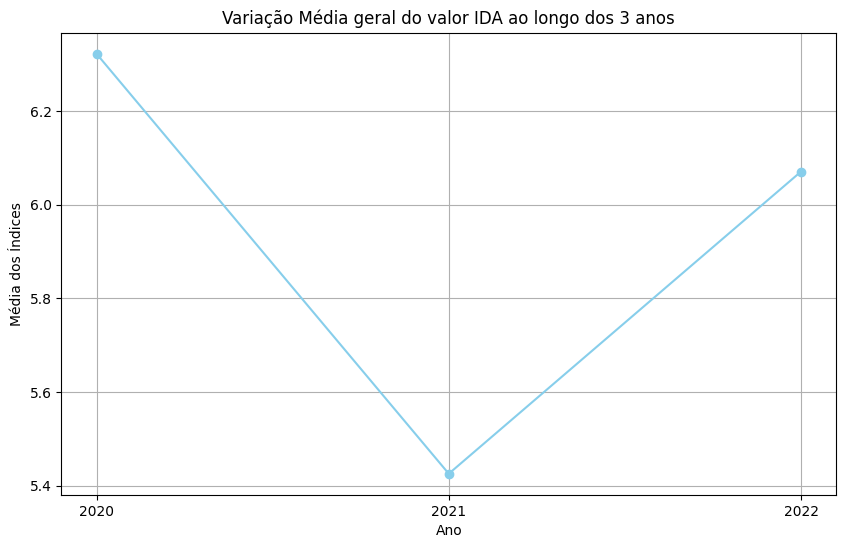

In [25]:
# Definir os anos e as médias
anos = ['2020', '2021', '2022']
valores = media_ida.values

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(anos, valores, marker='o', linestyle='-', color='skyblue')
plt.title('Variação Média geral do valor IDA ao longo dos 3 anos')
plt.xlabel('Ano')
plt.ylabel('Média dos Índices')
plt.grid(True)
plt.show()

In [26]:
df.nunique()

INSTITUICAO_ENSINO_ALUNO_2020       8
NOME                             1349
IDADE_ALUNO_2020                   15
ANOS_PM_2020                        6
FASE_TURMA_2020                    63
                                 ... 
INDICADO_BOLSA_2022                 2
PONTO_VIRADA_2022                   2
IPV_2022                          178
IAN_2022                            3
NIVEL_IDEAL_2022                    9
Length: 69, dtype: int64

In [27]:
# VALOR MÁXIMO REGISTRADO #

max_value = df_dados['preco_brent'].max()
print(max_value)

NameError: name 'df_dados' is not defined

In [214]:
# VALOR MÍNIMO REGISTRADO #

min_value = df_dados['preco_brent'].min()
print(min_value)

9.1


In [215]:
# VALOR MÉDIO #

mean_value = df_dados['preco_brent'].mean()
print(mean_value)

53.11047844327412


In [216]:
# DESVIO PADRÃO #

desvio_padrao = df_dados['preco_brent'].std()
print(desvio_padrao)

33.21582115966959


In [217]:
# MEDIANA #

mediana = df_dados['preco_brent'].median()
print(mediana)

48.4


In [218]:
# PRIMEIRO QUARTIL 25% #

primeiro_quartil = df_dados['preco_brent'].quantile(0.25)
print(primeiro_quartil)

20.53


In [219]:
# SEGUNDO QUARTIL 50% #

segundo_quartil = df_dados['preco_brent'].quantile(0.50)
print(segundo_quartil)

48.4


In [220]:
# TERCEIRO QUARTIL 75% #

terceiro_quartil = df_dados['preco_brent'].quantile(0.75)
print(terceiro_quartil)

76.61


In [221]:
df.info()
df.columns = ['ds', 'y']
df.to_csv('assets/csv/timeseries-petroleo-brent.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11203 non-null  datetime64[ns]
 1   preco_brent  11203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.2 KB


In [222]:
df.columns = ['data', 'preco_brent']

<Axes: xlabel='preco_brent', ylabel='Count'>

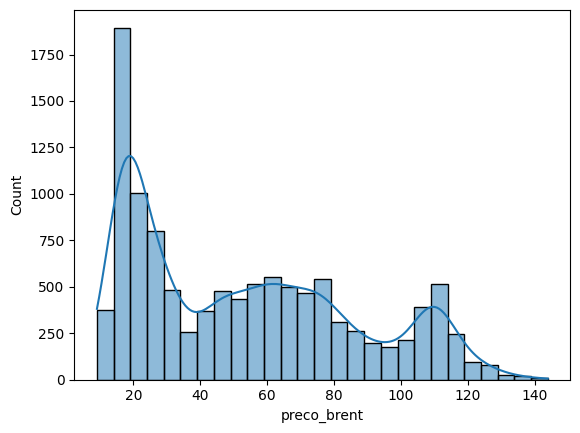

In [223]:
# GERANDO O HISTOGRAMA

sns.histplot(data=df.preco_brent, kde=True)

<Axes: ylabel='preco_brent'>

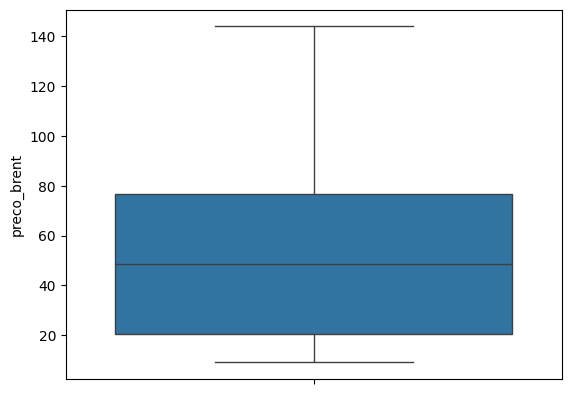

In [224]:
# GERANDO O BOXPLOT

sns.boxplot(data=df.preco_brent)

In [225]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))


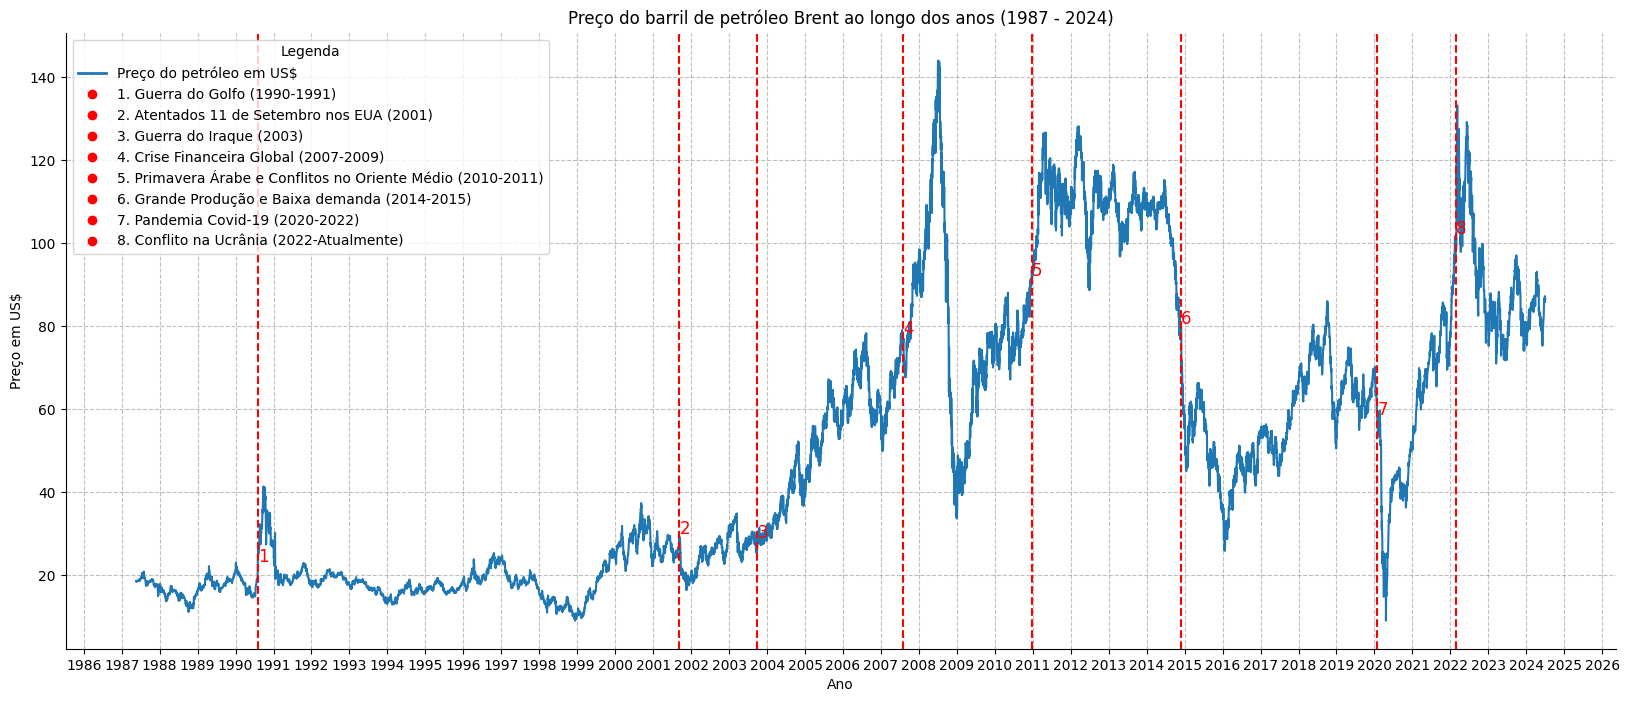

In [226]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))

# Função para configurar a legenda

def set_legenda():
    legend_handles, _ = plt.gca().get_legend_handles_labels()
    extra_labels = [
        ('Preço do petróleo em US$', '#1F77B4', 'line'),
        ('1. Guerra do Golfo (1990-1991)', 'red', 'dot'),
        ('2. Atentados 11 de Setembro nos EUA (2001)', 'red', 'dot'),
        ('3. Guerra do Iraque (2003)', 'red', 'dot'),
        ('4. Crise Financeira Global (2007-2009)', 'red', 'dot'),
        ('5. Primavera Árabe e Conflitos no Oriente Médio (2010-2011)', 'red', 'dot'),
        ('6. Grande Produção e Baixa demanda (2014-2015)', 'red', 'dot'),
        ('7. Pandemia Covid-19 (2020-2022)', 'red', 'dot'),
        ('8. Conflito na Ucrânia (2022-Atualmente)', 'red', 'dot')
    ]

    for label, color, linestyle in extra_labels:
        if linestyle == 'line':
            legend_handles.append(Line2D([0], [0], color=color, lw=2, label=label))
        elif linestyle == 'dot':
            legend_handles.append(Line2D([0], [0], color=color, marker='o', linestyle='', label=label))

    plt.legend(title='Legenda', loc='upper left', handles=legend_handles)

# Função para plotar eventos importantes
def plot_eventos(df_evento, evento_id):
    for _, row in df_evento.iterrows():
        plt.axvline(x=row['data'], color='red', linestyle='--')
        plt.text(row['data'], row['preco_brent'], str(evento_id), color='red', fontsize=12, verticalalignment='bottom')


# Configurarando o gráfico
plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=df, x='data', y='preco_brent', legend=False)
ax.set_ylabel('Preço em US$')
ax.set_xlabel('Ano')
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Plotar os eventos importantes
plot_eventos(df.query('data == "1990-08-02"'), 1)
plot_eventos(df.query('data == "2001-09-11"'), 2)
plot_eventos(df.query('data == "2003-10-01"'), 3)
plot_eventos(df.query('data == "2007-08-01"'), 4)
plot_eventos(df.query('data == "2010-12-20"'), 5)
plot_eventos(df.query('data == "2014-11-28"'), 6)
plot_eventos(df.query('data == "2020-01-30"'), 7)
plot_eventos(df.query('data == "2022-02-24"'), 8)

# Configurações finais do gráfico
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.despine()
set_legenda()
plt.title('Preço do barril de petróleo Brent ao longo dos anos (1987 - 2024)')
plt.show()


In [227]:
def dados_ml() -> pd.DataFrame:
  return df.query('data >= "2015-01-01"')

In [228]:
df_ml = dados_ml()
df_ml.columns = ['ds', 'y']
df_ml.head()

,ds,y
8387,2015-01-01,55.27
8388,2015-01-02,57.86
8389,2015-01-03,55.60
8390,2015-01-04,55.27
8391,2015-01-05,55.27


In [229]:
# https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
def parametros_prophet(train_data: pd.DataFrame):
  param_grid = {
      'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
  }

  # todas combinações de parâmetros configuradas
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []

  # cross_validation para avaliar todos os parâmetros
  for params in all_params:
      m = Prophet(**params).fit(train_data)
      df_cv = cross_validation(m, horizon='30 days', parallel="processes")
      df_p = performance_metrics(df_cv, rolling_window=1)
      rmses.append(df_p['rmse'].values[0])

  # procurando os melhores hiperparâmetros
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  print(tuning_results)

  # melhores parâmetros
  best_params = all_params[np.argmin(rmses)]
  print(best_params)

In [230]:
#parametros_prophet(df_ml)

In [231]:
# cria o modelo do prophet com os melhores hiperparâmetros
modelo = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01)
modelo.add_country_holidays(country_name='BR')
modelo.fit(df_ml)

00:51:23 - cmdstanpy - INFO - Chain [1] start processing
00:51:24 - cmdstanpy - INFO - Chain [1] done processing


In [232]:
# faz a previsão dos próximos 30 dias para o preço do barril de petróleo do tipo Brent

df_futuro = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(df_futuro)
previsao.tail(45)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ano novo,Ano novo_lower,Ano novo_upper,Carnaval,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2801,2024-06-11,75.249508,70.784885,87.047225,75.249508,75.249508,0.0,0.0,0.0,0.0,...,0.083335,0.083335,0.083335,3.822965,3.822965,3.822965,0.0,0.0,0.0,79.155808
2802,2024-06-12,75.214242,70.920116,86.885188,75.214242,75.214242,0.0,0.0,0.0,0.0,...,-0.059385,-0.059385,-0.059385,3.853370,3.853370,3.853370,0.0,0.0,0.0,79.008228
2803,2024-06-13,75.178976,71.029584,87.380932,75.178976,75.178976,0.0,0.0,0.0,0.0,...,-0.037011,-0.037011,-0.037011,3.888443,3.888443,3.888443,0.0,0.0,0.0,79.030408
2804,2024-06-14,75.143710,71.129901,87.976035,75.143710,75.143710,0.0,0.0,0.0,0.0,...,0.084322,0.084322,0.084322,3.926816,3.926816,3.926816,0.0,0.0,0.0,79.154848
2805,2024-06-17,75.037912,71.024625,86.981032,75.037912,75.037912,0.0,0.0,0.0,0.0,...,0.216166,0.216166,0.216166,4.045687,4.045687,4.045687,0.0,0.0,0.0,79.299765
2806,2024-06-18,75.002646,71.643119,87.844839,75.002646,75.002646,0.0,0.0,0.0,0.0,...,0.083335,0.083335,0.083335,4.080786,4.080786,4.080786,0.0,0.0,0.0,79.166767
2807,2024-06-19,74.967380,71.190998,86.540311,74.967380,74.967380,0.0,0.0,0.0,0.0,...,-0.059385,-0.059385,-0.059385,4.110717,4.110717,4.110717,0.0,0.0,0.0,79.018712
2808,2024-06-20,74.932114,71.308317,86.756482,74.932114,74.932114,0.0,0.0,0.0,0.0,...,-0.037011,-0.037011,-0.037011,4.133842,4.133842,4.133842,0.0,0.0,0.0,79.028946
2809,2024-06-21,74.896848,71.204818,87.548323,74.896848,74.896848,0.0,0.0,0.0,0.0,...,0.084322,0.084322,0.084322,4.148665,4.148665,4.148665,0.0,0.0,0.0,79.129836
2810,2024-06-24,74.791050,71.607649,87.190549,74.791050,74.791050,0.0,0.0,0.0,0.0,...,0.216166,0.216166,0.216166,4.131401,4.131401,4.131401,0.0,0.0,0.0,79.138618


In [233]:
# plot dos preços históricos (desde 2015) + janela de previsão

fig = plot_plotly(modelo, previsao, trend=True, figsize=(1200, 900))

# checando as configs criadas pelo Plotly

print(fig)

linha_azul = go.Scatter(x=[2015, previsao.iloc[-1, :].ds], y=[0, 0], mode='lines', line=dict(color='blue'), name='US$ 0,00')
linha_amarela = go.Scatter(x=[2015, previsao.iloc[-1, :].ds], y=[50, 50], mode='lines', line=dict(color='gold'), name='US$ 50,00')
linha_vermelha = go.Scatter(x=[2015, previsao.iloc[-1,:].ds], y=[100, 100], mode='lines', line=dict(color='red'), name='US$ 100,00')
fig.update_layout(title='Distribuição do valor (US$) do barril de petróleo Brent entre 2015 e os dias atuais + previsão dos próximos 30 dias', showlegend=True)
fig.data[0].name = 'Realidade'
fig.data[1].name = 'Banda inferior da previsão'
fig.data[1].fill = 'tonexty'
fig.data[1].fillcolor = 'rgba(0, 114, 178, 0.2)'
fig.data[2].name = 'Previsão'
fig.data[3].name = 'Banda superior da previsão'
fig.data[4].name = 'Tendência'
fig.add_trace(linha_azul)
fig.add_trace(linha_amarela)
fig.add_trace(linha_vermelha)
fig.show()

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 3, 0, 0), ...,
                          datetime.datetime(2024, 6, 27, 0, 0),
                          datetime.datetime(2024, 6, 28, 0, 0),
                          datetime.datetime(2024, 7, 1, 0, 0)], dtype=object),
              'y': array([55.27, 57.86, 55.6 , ..., 87.  , 87.26, 86.57])},
             {'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 3, 0, 0), ...,
                          dateti

In [234]:
plot_components_plotly(modelo, previsao)

In [235]:
print(fig)

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Realidade',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 3, 0, 0), ...,
                          datetime.datetime(2024, 6, 27, 0, 0),
                          datetime.datetime(2024, 6, 28, 0, 0),
                          datetime.datetime(2024, 7, 1, 0, 0)], dtype=object),
              'y': array([55.27, 57.86, 55.6 , ..., 87.  , 87.26, 86.57])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'name': 'Banda inferior da previsão',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                      

In [236]:
def calcular_mape_previsao(previsao: pd.DataFrame, train_data: pd.DataFrame):
  
  # extrair as colunas relevantes dos dataframes

  previsao_cols = ['ds', 'yhat']
  valores_reais_cols = ['ds', 'y']

  previsao = previsao[previsao_cols]
  valores_reais = train_data[valores_reais_cols]

  # merge os dataframes nas colunas 'ds' para comparar previsões e valores reais
  
  resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

  # calcula o erro percentual absoluto para cada ponto de dados
  
  resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

  # cálculo do MAPE
  
  mape = np.mean(resultados['erro_percentual_absoluto'])
  mape_decimal = np.round(mape / 100, 2)

  print(f'MAPE decimal: {mape_decimal:.2f}')
  print(f"MAPE: {mape:.8f}%")

In [237]:
calcular_mape_previsao(previsao, df_ml)


MAPE decimal: 0.08
MAPE: 8.11621280%


In [238]:
df_cv = cross_validation(modelo, horizon='120 days', parallel="processes")
df_p = performance_metrics(df_cv)
print(df_p)

     horizon         mse       rmse        mae      mape     mdape     smape  \
0    12 days  146.813785  12.116674   8.039121  0.140092  0.072929  0.126277   
1    13 days  150.893742  12.283881   8.165182  0.142639  0.073641  0.128446   
2    14 days  156.618589  12.514735   8.369809  0.146333  0.077112  0.131669   
3    15 days  161.413937  12.704878   8.559368  0.149461  0.082364  0.134551   
4    16 days  168.783656  12.991676   8.845776  0.156067  0.084592  0.139366   
..       ...         ...        ...        ...       ...       ...       ...   
104 116 days  509.484205  22.571757  17.153691  0.280612  0.208504  0.294075   
105 117 days  519.709632  22.797141  17.304162  0.282678  0.208197  0.296148   
106 118 days  525.884499  22.932172  17.388195  0.284195  0.206595  0.297950   
107 119 days  537.354072  23.180899  17.599669  0.289942  0.208251  0.303367   
108 120 days  538.414422  23.203759  17.579429  0.289285  0.207911  0.304141   

     coverage  
0    0.399403  
1    0.

EXPORTANDO O MODELO

In [239]:
# prepara o dataframe de performance
df_max_date = df_ml.ds.max()
df_p['dias_no_futuro'] = df_p['horizon'].apply(lambda horizon: int(str(horizon).split(' ')[0]))
df_p['data_no_futuro'] = df_p['dias_no_futuro'].apply(lambda dias: df_ml.ds.max() + timedelta(days=dias))
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,dias_no_futuro,data_no_futuro
0,12 days,146.813785,12.116674,8.039121,0.140092,0.072929,0.126277,0.399403,12,2024-07-13
1,13 days,150.893742,12.283881,8.165182,0.142639,0.073641,0.128446,0.394646,13,2024-07-14
2,14 days,156.618589,12.514735,8.369809,0.146333,0.077112,0.131669,0.389053,14,2024-07-15
3,15 days,161.413937,12.704878,8.559368,0.149461,0.082364,0.134551,0.379193,15,2024-07-16
4,16 days,168.783656,12.991676,8.845776,0.156067,0.084592,0.139366,0.369737,16,2024-07-17
...,...,...,...,...,...,...,...,...,...,...
104,116 days,509.484205,22.571757,17.153691,0.280612,0.208504,0.294075,0.648452,116,2024-10-25
105,117 days,519.709632,22.797141,17.304162,0.282678,0.208197,0.296148,0.645493,117,2024-10-26
106,118 days,525.884499,22.932172,17.388195,0.284195,0.206595,0.297950,0.646776,118,2024-10-27
107,119 days,537.354072,23.180899,17.599669,0.289942,0.208251,0.303367,0.642251,119,2024-10-28


In [240]:
df_p.to_csv('assets/csv/prophet-performance.csv', index=False)

In [241]:
with open('assets/csv/prophet-model.json','w') as f_out:
    f_out.write(model_to_json(modelo))